In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy
import sys
from matplotlib.path import Path

In [2]:
def read_fits(name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data, header

# Step 1. We load the different files

In [17]:
field_list = ['12', '16']

In [18]:
data_dictionary = {}
coordinates_dictionary = {}
print('We have loaded the following files:')
for field in field_list:
    data_dictionary[field], header = read_fits('/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field))
    coordinates_dictionary[field] = SkyCoord(data_dictionary[field]['RA'], data_dictionary[field]['DEC'], unit = 'deg')
    print field

We have loaded the following files:
12
16


# Step 2. We find the distances between all stars

In [14]:
for field in field_list:
    field_coordinates = coordinates_dictionary[field]
    for star in field_coordinates:
        all_distances = 

<SkyCoord (ICRS): (ra, dec) in deg
    [(15.90476785, -74.56239271), (15.92003673, -74.54928515),
     (16.05310659, -74.55173814), ..., (16.84750738, -74.94922557),
     (18.89483709, -74.94452378), (16.92823194, -75.38643206)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(20.79604346, -73.4388173 ), (20.79242883, -73.49742692),
     (20.79880173, -73.51437226), ..., (23.09667219, -74.86804309),
     (24.66426421, -75.02156516), (24.5574442 , -75.02267122)]>


In [ ]:
separation_dictionary = {}
for i, star in enumerate(coordinates_dictionary['12']):
    separation_dictionary[i] = star.separation(coordinates_dictionary['16'])

In [ ]:
plt.hist(separation_dictionary[0])
plt.show()

# Scrap everything, we are starting all over again

In [7]:
!python /user/HS128/pm00518/virtualenvs/venv/bin/nway-write-header.py /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz 16 2.8 

current 12 SKYAREA: 2.81
new     16 SKYAREA: 2.8


In [8]:
!python /user/HS128/pm00518/virtualenvs/venv/bin/nway-write-header.py /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz 12 2.81

current  SKYAREA: None
new     12 SKYAREA: 2.81


In [15]:
output_file = '/user/HS128/pm00518/SMASH_maps/output_test_12_16.fits'

In [18]:
!python nway.py /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz :RAERR /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz :RAERR --out=/scratch/SMASH_DATA/SMC_contiguous_catalogue/output_test_12_16.fits --radius 2

NWAY arguments:
    catalogues:  /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz, /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz
    position errors/columns:  :RAERR, :RAERR
      from catalogue "16" (392250), density gives 5.78e+09 on entire sky
      from catalogue "12" (515997), density gives 7.58e+09 on entire sky
    magnitude columns:  

matching with 2.000000 arcsec radius
matching: 202399823250 naive possibilities
matching: hashing
    using RA  columns: RA, RA
    using DEC columns: DEC, DEC
matching: healpix hashing on pixel resolution ~ 2.254538 arcsec (nside=65536)
100%|908247|####################################################|Time:  0:00:08
matching: collecting from 2136361 buckets, creating cartesian products ...
100%|2136361|###################################################|Time:  0:00:07
matching: 486159 unique matches from cartesian product. sorting ...
merging in 74 columns from input catalogues ...
100%| 74|#####################################################

In [21]:
!python nway.py /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz :RAERR /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz :RAERR --out=/scratch/SMASH_DATA/SMC_contiguous_catalogue/output_test2_12_16.fits --radius 2 --mag 16:G auto --mag-radius 1

NWAY arguments:
    catalogues:  /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz, /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz
    position errors/columns:  :RAERR, :RAERR
      from catalogue "16" (392250), density gives 5.78e+09 on entire sky
      from catalogue "12" (515997), density gives 7.58e+09 on entire sky
    magnitude columns:  16:G

matching with 2.000000 arcsec radius
matching: 202399823250 naive possibilities
matching: hashing
    using RA  columns: RA, RA
    using DEC columns: DEC, DEC
merging in 74 columns from input catalogues ...
100%| 74|#######################################################|Time:  0:00:02
    adding angular separation columns
matching: 407746 matches after filtering by search radius

Computing distance-based probabilities ...
  finding position error columns ...
    Position error for "16": found column 16_RAERR: Values are [0.002633..1.140573]
    Position error for "12": found column 12_RAERR: Values are [0.002665..1.394844]
  finding posi

Ok so, so far we have established that we will use nway, but it is actually more tricky to work with than expected.

The strategy now will be to create a file that has all of the information from all fields and then we will cross-match this with all the different fields. Then, we will remove all the duplicates and make a decision about what to do with the pairs from different fields. We also have to manually look at the magnitudes to see which is the best match.

# Stack all fields in 1 file

In [23]:
field_list = ['11', '12', '16']
data_path = '/scratch/SMASH_DATA/'
important_data = np.empty((6,0))

for field in field_list:
    temp_data, temp_header = read_fits(data_path+'Field%s_allobj_stars.fits.gz'%(field))
    important_temp_data = temp_data['ID'], temp_data['RA'], temp_data['DEC'], temp_data['RAERR'], temp_data['G'], temp_data['GERR']
    print(len(temp_data['RA']))
    #important_data = np.empty_like(important_temp_data)
    #print(important_data.shape)
    important_data = np.hstack((important_data, important_temp_data))

1253592
515997
392250


In [25]:
print(important_data)

[['Field11.2      ' 'Field11.4      ' 'Field11.5      ' ...
  'Field16.1611682' 'Field16.1611684' 'Field16.1611685']
 ['15.02660523874578' '15.639410378068849' '15.741039767016154' ...
  '23.096672194573284' '24.66426421012263' '24.557444198987422']
 ['-73.02799942079099' '-72.99136596252471' '-72.93967314621855' ...
  '-74.86804308787266' '-75.02156515752779' '-75.02267122138626']
 ['0.0063623064' '0.0069762454' '0.014305071' ... '0.006152988'
  '0.008114379' '0.007278092']
 ['19.147987' '19.41717' '21.236536' ... '17.627884' '17.113459'
  '18.16932']
 ['0.002845573' '0.00269976' '0.009060527' ... '0.007122967'
  '0.007244018' '0.0071695526']]


In [29]:
wcs = WCS(temp_header)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 386  392250


TypeError: cannot perform reduce with flexible type

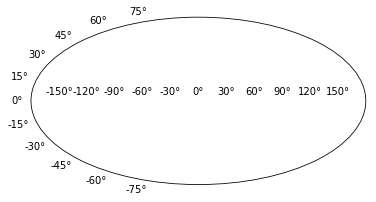

In [40]:
plt.subplot(projection='aitoff')
image, xbins, ybins = np.histogram2d(important_data[1], important_data[2])
plt.imshow(image, interpolation=None)
plt.show()

In [33]:
matplotlib.projections.get_projection_names()

['aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear']